In [237]:
import pandas as pd
import numpy as np

## Cargamos los datos

Cargamos los datos de ratings, books, tags y book_tags, generando un dataframe ratings_matrix, que será matriz R que vamos a usar para el modelo de KNN.

In [238]:
ratings = pd.read_csv('./data/ratings.csv')
to_read = pd.read_csv('./data/to_read.csv')
books = pd.read_csv('./data/books.csv')
book_tags = pd.read_csv('./data/book_tags.csv')
tags = pd.read_csv('./data/tags.csv')

print("Ratings shape:", ratings.shape)
print("Books shape:", books.shape)
print("Tags shape:", tags.shape)

Ratings shape: (5976479, 3)
Books shape: (10000, 23)
Tags shape: (34252, 2)


In [239]:
# Generamos la matriz de ratings, que será una matriz libros x usuario, vemos que ocupa 4 GB

ratings_matrix = ratings.pivot(index='user_id', columns='book_id', values='rating')
ratings_matrix.info( memory_usage='deep' )

<class 'pandas.core.frame.DataFrame'>
Index: 53424 entries, 1 to 53424
Columns: 10000 entries, 1 to 10000
dtypes: float64(10000)
memory usage: 4.0 GB


# Generación de muestras.



In [240]:
# Muestra aleatoria de 1000 usuarios y 1000 libros (7.6 MB)

N = 1000 # Número de usuarios
M = 1000 # Número de libros

ratings_matrix_sample = ratings_matrix.sample(N, axis=0).sample(M, axis=1)
ratings_matrix_sample.info( memory_usage='deep' )

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 25976 to 9813
Columns: 1000 entries, 2954 to 7354
dtypes: float64(1000)
memory usage: 7.6 MB


In [241]:
# Muestra de 10 usuario y 1000 libros que intenta estar lo mas poblada posible para garantizar que haya coincidencias entre usuarios (85.9 KB)

N = 10 # Número de usuarios
M = 1000 # Número de libros

# Selecciona los 10 usuarios con más valoraciones
usuarios_top = ratings_matrix_sample.notna().sum(axis=1).sort_values(ascending=False).head(N).index

# Selecciona los 1000 libros con más valoraciones
libros_top = ratings_matrix_sample.notna().sum(axis=0).sort_values(ascending=False).head(M).index

mini_sample = ratings_matrix_sample.loc[usuarios_top, libros_top]
mini_sample.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 50133 to 22611
Columns: 1000 entries, 43 to 7286
dtypes: float64(1000)
memory usage: 78.2 KB


In [242]:
# Muestra de 1000 usuario y 1000 libros que intenta estar lo mas poblada posible para garantizar que haya coincidencias entre usuarios (7.6 MB)

N = 1000 # Número de usuarios
M = 1000 # Número de libros

# Selecciona los 10 usuarios con más valoraciones
usuarios_top = ratings_matrix_sample.notna().sum(axis=1).sort_values(ascending=False).head(M).index

# Selecciona los 1000 libros con más valoraciones
libros_top = ratings_matrix_sample.notna().sum(axis=0).sort_values(ascending=False).head(N).index

mid_sample = ratings_matrix_sample.loc[usuarios_top, libros_top]
mid_sample.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 50133 to 50706
Columns: 1000 entries, 43 to 7286
dtypes: float64(1000)
memory usage: 7.6 MB


A continuación se definen las funciones que se van a usar para el modelo de KNN. Y se hacen pruebas con la muestra de 10 usuarios y 1000 libros.

## Media de un usuario

In [243]:
def media_usuario(user_id, matrix = ratings_matrix):
    """Devuelve la puntuación media de un usuario usando"""
    if user_id not in matrix.index:
        return None
    ratings = matrix.loc[user_id].dropna()
    if len(ratings) == 0:
        return None
    return np.mean(ratings)

In [244]:
usuarios = mini_sample.index

print("Media de un usuario:", media_usuario(usuarios[0], mini_sample))

Media de un usuario: 5.0


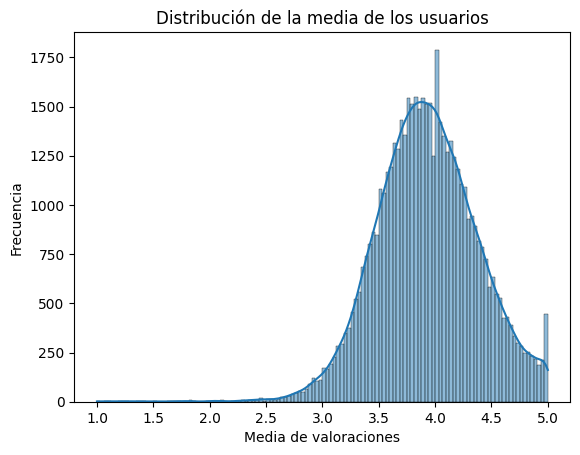

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(ratings_matrix.mean(axis=1), kde=True)
plt.title('Distribución de la media de los usuarios')
plt.xlabel('Media de valoraciones')
plt.ylabel('Frecuencia')
plt.show()

## Similitud entre usuarios (Jaccard-MSD)

In [246]:
def jmsd_similarity(u, v, matrix=ratings_matrix, print=False):
    """
    Calcula la similitud JMSD entre dos usuarios (u, v) en una matriz libros x usuarios.
    """
    if u not in matrix.index or v not in matrix.index:
        if print:
            print('usuario no encontrado')
        return None

    ratings_u = matrix.loc[u]
    ratings_v = matrix.loc[v]

    # Selecciona solo los libros que ambos han valorado
    mask = ratings_u.notna() & ratings_v.notna()
    if mask.sum() == 0:
        if print:
            print('no hay libros en común')
        return None

    r_u = ratings_u[mask]
    r_v = ratings_v[mask]

    # Normaliza las valoraciones
    MIN_RATING = matrix.min().min()
    MAX_RATING = matrix.max().max()
    r_u_norm = (r_u - MIN_RATING) / (MAX_RATING - MIN_RATING)
    r_v_norm = (r_v - MIN_RATING) / (MAX_RATING - MIN_RATING)

    msd = np.mean((r_u_norm - r_v_norm) ** 2)
    jaccard = mask.sum() / ((ratings_u.notna() | ratings_v.notna()).sum())

    return jaccard * (1 - msd)

In [247]:
users = mini_sample.index
jmsd_similarity(sample_users[1], sample_users[2], ratings_matrix_sample)

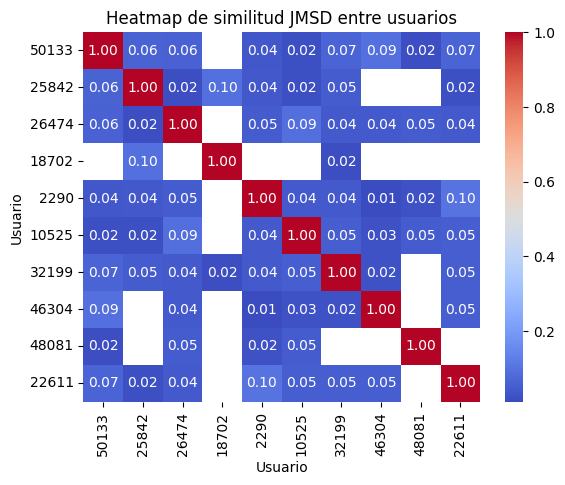

In [258]:
# Vamos a generar un heatmap de similitud entre usuarios
usuarios = mini_sample.index

sim_matrix = np.zeros((len(usuarios), len(usuarios)))

for i, u1 in enumerate(usuarios):
    for j, u2 in enumerate(usuarios):
        if i <= j:
            sim = jmsd_similarity(u1, u2, mini_sample)
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim  # simétrica


sim_df = pd.DataFrame(sim_matrix, index=usuarios, columns=usuarios)

sns.heatmap(sim_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de similitud JMSD entre usuarios")
plt.xlabel("Usuario")
plt.ylabel("Usuario")
plt.show()



## Buscar los k vecinos más cercanos

In [250]:
from tqdm import tqdm

In [260]:
def k_nearest_neighbors(user_id, k=5, matrix=ratings_matrix, use_tqdm=True):
    """
    Devuelve los k vecinos más cercanos a un usuario dado en una matriz libros x usuarios.
    """
    if user_id not in matrix.index:
        print('usuario no encontrado')
        return None

    similarities = []

    if use_tqdm:
        iterador = tqdm(matrix.index)
    else:
        iterador = matrix.index

    for other_user in iterador:
        if other_user != user_id:
            sim = jmsd_similarity(user_id, other_user, matrix)
            if sim is not None:
                similarities.append((other_user, sim))

    # Ordena por similitud y selecciona los k más cercanos
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:k]

In [264]:
usuarios = mid_sample.index

k_nearest_neighbors(usuarios[0], k=5, matrix=mid_sample)

100%|██████████| 1000/1000 [00:12<00:00, 77.08it/s]


[(7295, np.float64(0.19507575757575757)),
 (52469, np.float64(0.1794871794871795)),
 (18760, np.float64(0.16856060606060608)),
 (22171, np.float64(0.16098484848484848)),
 (44572, np.float64(0.1484375))]

In [267]:
usuarios = ratings_matrix.index

k_nearest_neighbors(usuarios[0], k=5, matrix=ratings_matrix)

# Como vemos la matriz de 4GB es muy grande para ejecutar KNN en un tiempo razonable.

  0%|          | 2/53424 [00:40<303:23:21, 20.44s/it]


KeyboardInterrupt: 

## Estimar predicciones

In [284]:
def deviation_from_mean_prediction(usuario, libro, neighbors, matrix=ratings_matrix_sample):
    """
    Devuelve la predicción de un libro para un usuario dado usando el método de desviación de la media.
    """
    acc = 0
    count = 0

    for n in neighbors:
        if n is None:
            break
        # Verifica si el vecino tiene valoración para el libro i
        if libro in matrix.columns and not pd.isna(matrix.loc[n, libro]):
            avg_n = media_usuario(n, matrix)
            acc += matrix.loc[n, libro] - avg_n
            count += 1

    if count > 0:
        avg_u = media_usuario(usuario, matrix)
        prediction = avg_u + acc / count
        return prediction
    else:
        #print('No hay vecinos con valoraciones para el libro')
        return None

In [285]:
usuarios = mini_sample.index
libros = mini_sample.columns

usuario = usuarios[0]
libro = libros[0]

In [286]:
vecinos = k_nearest_neighbors(usuario, k=25, matrix=ratings_matrix_sample)
vecinos_id = [n[0] for n in vecinos]

100%|██████████| 1000/1000 [00:15<00:00, 65.25it/s]


In [278]:
pred = deviation_from_mean_prediction(usuario, libro, vecinos_id, matrix=ratings_matrix_sample)

In [287]:
# Aqui vemos que podemos predecir la puntuación de un libro para un usuario dado.

for libro in sample_libros:
    pred = deviation_from_mean_prediction(usuario, libro, vecinos_id, matrix=ratings_matrix_sample)
    if pred is not None:
        print(f"Predicción para el libro {libro}: {pred:.2f}")
    else:
        pass
        # print(f"No se pudo hacer la predicción para el libro {libro}")

Predicción para el libro 191: 5.53
Predicción para el libro 156: 5.00
Predicción para el libro 223: 5.09
Predicción para el libro 145: 4.97
Predicción para el libro 101: 4.83
Predicción para el libro 462: 5.00
Predicción para el libro 954: 5.29
Predicción para el libro 1577: 5.50
Predicción para el libro 5650: 5.00
Predicción para el libro 663: 5.91
Predicción para el libro 2663: 3.93
Predicción para el libro 2618: 4.72
Predicción para el libro 5580: 5.22
Predicción para el libro 511: 4.40
Predicción para el libro 4054: 5.44
Predicción para el libro 308: 4.60
Predicción para el libro 3753: 6.50
Predicción para el libro 4080: 5.92
Predicción para el libro 6466: 5.00
Predicción para el libro 687: 5.56
Predicción para el libro 514: 5.34
Predicción para el libro 589: 5.00
Predicción para el libro 7469: 5.22
Predicción para el libro 1715: 5.00
Predicción para el libro 868: 5.03
Predicción para el libro 887: 6.50
Predicción para el libro 3415: 5.12
Predicción para el libro 6374: 4.69
Predicc

In [290]:
def get_predictions(usuario, libros, vecinos_id, matrix):
    """
    Devuelve todas las predicciones ordenadas de un usuario (prediccion, libro).
    """
    predicciones = []

    for libro in libros:
        pred = deviation_from_mean_prediction(usuario, libro, vecinos_id, matrix=matrix)
        if pred is not None:
            predicciones.append((libro, pred))
        # Si es None, simplemente no se añade

    # Ordena por la predicción (valor), de mayor a menor, y toma los n primeros
    return sorted(predicciones, key=lambda x: x[1], reverse=True)

In [291]:
get_predictions(usuario, sample_libros, vecinos_id, ratings_matrix_sample)

[(3753, np.float64(6.5)),
 (887, np.float64(6.5)),
 (1338, np.float64(6.5)),
 (4494, np.float64(6.0)),
 (5010, np.float64(5.928571428571429)),
 (1294, np.float64(5.920350482850483)),
 (4080, np.float64(5.916666666666667)),
 (255, np.float64(5.916666666666667)),
 (663, np.float64(5.9125874125874125)),
 (2020, np.float64(5.846153846153846)),
 (691, np.float64(5.846153846153846)),
 (1717, np.float64(5.75)),
 (1160, np.float64(5.75)),
 (735, np.float64(5.6875)),
 (3583, np.float64(5.666666666666667)),
 (4345, np.float64(5.666666666666667)),
 (661, np.float64(5.653846153846153)),
 (250, np.float64(5.615384615384615)),
 (3985, np.float64(5.615384615384615)),
 (424, np.float64(5.615384615384615)),
 (687, np.float64(5.555555555555555)),
 (1507, np.float64(5.555555555555555)),
 (191, np.float64(5.533088235294118)),
 (278, np.float64(5.505685511384041)),
 (1577, np.float64(5.5)),
 (109, np.float64(5.5)),
 (102, np.float64(5.4990431300725415)),
 (43, np.float64(5.462614468864469)),
 (3363, np.flo

## Conseguir recomendaciones

In [292]:
def get_recommendations (usuario, sample_libros, vecinos_id, ratings_matrix_sample, n=10):
    """
    Devuelve las n mejores recomendaciones para un usuario dado, simplemente genera las predicciones y trunca segun el numero deseado.
    """

    prediccciones = get_predictions(usuario, sample_libros, vecinos_id, ratings_matrix_sample)
    return prediccciones[:n] # Devuelve las 5 mejores recomendaciones

get_recommendations(usuario, sample_libros, vecinos_id, ratings_matrix_sample, n=10)

[(3753, np.float64(6.5)),
 (887, np.float64(6.5)),
 (1338, np.float64(6.5)),
 (4494, np.float64(6.0)),
 (5010, np.float64(5.928571428571429)),
 (1294, np.float64(5.920350482850483)),
 (4080, np.float64(5.916666666666667)),
 (255, np.float64(5.916666666666667)),
 (663, np.float64(5.9125874125874125)),
 (2020, np.float64(5.846153846153846))]

## Rellenar la matriz de ratings con las predicciones (Lo usaremos para evaluar el modelo)

In [293]:
import pandas as pd
import numpy as np

def generar_matriz_predicciones(matrix, k=10):
    usuarios = matrix.index
    libros = matrix.columns
    # Inicializa la matriz de predicciones con None
    pred_matrix = pd.DataFrame(None, index=usuarios, columns=libros)

    for usuario in tqdm(usuarios):
        vecinos = k_nearest_neighbors(usuario, k=k, matrix=matrix, use_tqdm=False)
        vecinos_id = [n[0] for n in vecinos]
        for libro in libros:
            pred = deviation_from_mean_prediction(usuario, libro, vecinos_id, matrix=matrix)
            if pred is not None:
                pred_matrix.loc[usuario, libro] = pred
    return pred_matrix

In [294]:
pred_mini_sample = generar_matriz_predicciones(mini_sample, k=5)

100%|██████████| 10/10 [00:00<00:00, 11.60it/s]


In [296]:
pred_mid_sample = generar_matriz_predicciones(mid_sample, k=5)

  3%|▎         | 27/1000 [04:26<2:39:46,  9.85s/it]


KeyboardInterrupt: 

# A continuacion las funciones que vamos a usar para evaluar el modelo.

## Calcular RMSE y MAE

In [298]:
def calcular_errores(matrix_real, matrix_pred):
    errores = []
    for usuario in matrix_real.index:
        for libro in matrix_real.columns:
            real = matrix_real.loc[usuario, libro]
            pred = matrix_pred.loc[usuario, libro]
            if not (pd.isna(real) or pd.isna(pred)):
                errores.append(abs(real - pred))
    if errores:
        return errores
    else:
        return None

def calcular_mae(errores):
    return np.mean(errores)

def calcular_rmse(errores):
    return np.sqrt(np.mean(np.square(errores)))


# Pequeño test
errores = calcular_errores(mini_sample, pred_mini_sample)
mae = calcular_mae(errores)
rmse = calcular_rmse(errores)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.6491905054405055
RMSE: 0.8153142768731614


## Precision

In [301]:
def get_user_precision(user_id, pred_matrix, test_matrix, theta=4, n=10):

    # Selecciona los libros con mayor predicción para el usuario
    user_preds = pred_matrix.loc[user_id].dropna().sort_values(ascending=False)
    top_n_books = user_preds.head(n).index

    precision = 0
    count = 0

    for book_id in top_n_books:
        real_rating = test_matrix.loc[user_id, book_id]
        if not np.isnan(real_rating):
            if real_rating >= theta:
                precision += 1
            count += 1

    if count > 0:
        return precision / count
    else:
        return None

def get_all_precisions(pred_matrix, test_matrix, theta=4, n=10):
    precisions = []
    for user_id in pred_matrix.index:
        user_precision = get_user_precision(user_id, pred_matrix, test_matrix, theta=theta, n=n)
        if user_precision is not None:
            precisions.append(user_precision)
    return precisions

def get_precision(pred_matrix, test_matrix, theta=4, n=10):
    precisions = get_all_precisions(pred_matrix, test_matrix, theta=theta, n=n)
    if precisions:
        return np.mean(precisions)
    else:
        return None

# Pequeño test
usuarios = mini_sample.index
precision_lista = get_all_precisions(pred_mini_sample, mini_sample, theta=4, n=10)
precision_media = get_precision(pred_mini_sample, mini_sample, theta=4, n=10)
print("Precisión por usuario:", precision_lista)
print("Precisión media:", precision_media)

Precisión por usuario: [1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
Precisión media: 0.8333333333333334


In [305]:
import numpy as np

def get_user_recall(user_id, pred_matrix, test_matrix, theta=4, n=10):
    """
    Calcula el recall para un usuario dado.
    """
    # Libros relevantes en test
    relevant_books = test_matrix.loc[user_id][test_matrix.loc[user_id] >= theta].dropna().index
    if len(relevant_books) == 0:
        return None

    # Libros recomendados (top-n predicciones)
    user_preds = pred_matrix.loc[user_id].dropna().sort_values(ascending=False)
    top_n_books = user_preds.head(n).index

    # Libros relevantes recomendados
    hits = len(set(top_n_books) & set(relevant_books))
    recall = hits / len(relevant_books)
    return recall

def get_all_recalls(pred_matrix, test_matrix, theta=4, n=10):
    recalls = []
    for user_id in pred_matrix.index:
        user_recall = get_user_recall(user_id, pred_matrix, test_matrix, theta=theta, n=n)
        if user_recall is not None:
            recalls.append(user_recall)
    return recalls

def get_recall(pred_matrix, test_matrix, theta=4, n=10):
    recalls = get_all_recalls(pred_matrix, test_matrix, theta=theta, n=n)
    if recalls:
        return np.mean(recalls)
    else:
        return None

recall_lista = get_all_recalls(pred_mini_sample, mini_sample, theta=4, n=10)
recall_media = get_recall(pred_mini_sample, mini_sample, theta=4, n=10)

print("Recall por usuario:", recall_lista)
print("Recall medio:", recall_media)

Recall por usuario: [0.07407407407407407, 0.041666666666666664, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.058823529411764705, 0.14285714285714285, 0.0]
Recall medio: 0.048408807967631494


In [306]:
def get_user_f1(user_id, pred_matrix, test_matrix, theta=4, n=10):
    precision = get_user_precision(user_id, pred_matrix, test_matrix, theta=theta, n=n)
    recall = get_user_recall(user_id, pred_matrix, test_matrix, theta=theta, n=n)
    if precision is not None and recall is not None and (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return None

def get_all_f1s(pred_matrix, test_matrix, theta=4, n=10):
    f1s = []
    for user_id in pred_matrix.index:
        f1 = get_user_f1(user_id, pred_matrix, test_matrix, theta=theta, n=n)
        if f1 is not None:
            f1s.append(f1)
    return f1s

def get_f1(pred_matrix, test_matrix, theta=4, n=10):
    f1s = get_all_f1s(pred_matrix, test_matrix, theta=theta, n=n)
    if f1s:
        return np.mean(f1s)
    else:
        return None

f1_lista = get_all_f1s(pred_mini_sample, mini_sample, theta=4, n=10)
f1_media = get_f1(pred_mini_sample, mini_sample, theta=4, n=10)
print("F1 por usuario:", f1_lista)
print("F1 medio:", f1_media)

F1 por usuario: [0.13793103448275862, 0.07999999999999999, 0.2857142857142857, 0.1111111111111111, 0.25]
F1 medio: 0.1729512862616311


## Calculo final de metricas:

Usando la nuestra mediana calculamos las métricas del modelo.

In [ ]:
# FALTA EJECUTAR

pred_mid_matrix = generar_matriz_predicciones(mid_sample, k=5)

In [207]:
# Calcula métricas solo sobre mid_sample y sus predicciones
errores = calcular_errores(mid_sample, pred_mid_matrix)
mae = calcular_mae(errores)
rmse = calcular_rmse(errores)
precision_media = get_precision(pred_mid_matrix, mid_sample, theta=4, n=10)
recall_media = get_recall(pred_mid_matrix, mid_sample, theta=4, n=10)
f1_media = get_f1(pred_mid_matrix, mid_sample, theta=4, n=10)

print("MAE:", mae)
print("RMSE:", rmse)
print("Precisión media:", precision_media)
print("Recall medio:", recall_media)
print("F1 medio:", f1_media)

  0%|          | 0/53424 [07:45<?, ?it/s]


KeyboardInterrupt: 